In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import time

import nafflib



def cauchy(x,loc,scale):
    # from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cauchy.html
    return 1/(np.pi*scale*(1+((x-loc)/scale)**2))



def dense_spectrum(Q0,param,n_bands_Qs = 1,n_bands_dQ = 5):
    # Creating dummy signal with dense spectral lines
    #==============================================
    N  = np.arange(int(1e5))
    Q0 = 0.31025793875089835
    Qs = 0.002
    dQ = Qs/param
    Jx = (0.5*(10**2))

    i,j    = np.arange(-n_bands_dQ,n_bands_dQ+1),np.arange(-n_bands_Qs,n_bands_Qs+1)
    Ai,Aj  = cauchy(i/np.max(i),0,0.05),cauchy(j/np.max(j),0,0.05)
    Ai,Aj  = Ai/np.max(Ai),Aj/np.max(Aj)

    amplitudes  = np.array([[ (np.sqrt(2*Jx)*_Ai*_Aj) for _i,_Ai in zip(i,Ai) ] for _j,_Aj in zip(j,Aj) ]).flatten()
    frequencies = np.array([[Q0+ _j*Qs + _i*dQ for _i,_Ai in zip(i,Ai) ] for _j,_Aj in zip(j,Aj) ]).flatten() 

    Q_vec = [Q0,Qs,dQ]

    return amplitudes,frequencies,Q_vec,nafflib.generate_signal(amplitudes,frequencies,N)
    #==============================================




---
# Convergence
---

(2e-06, 100.0)

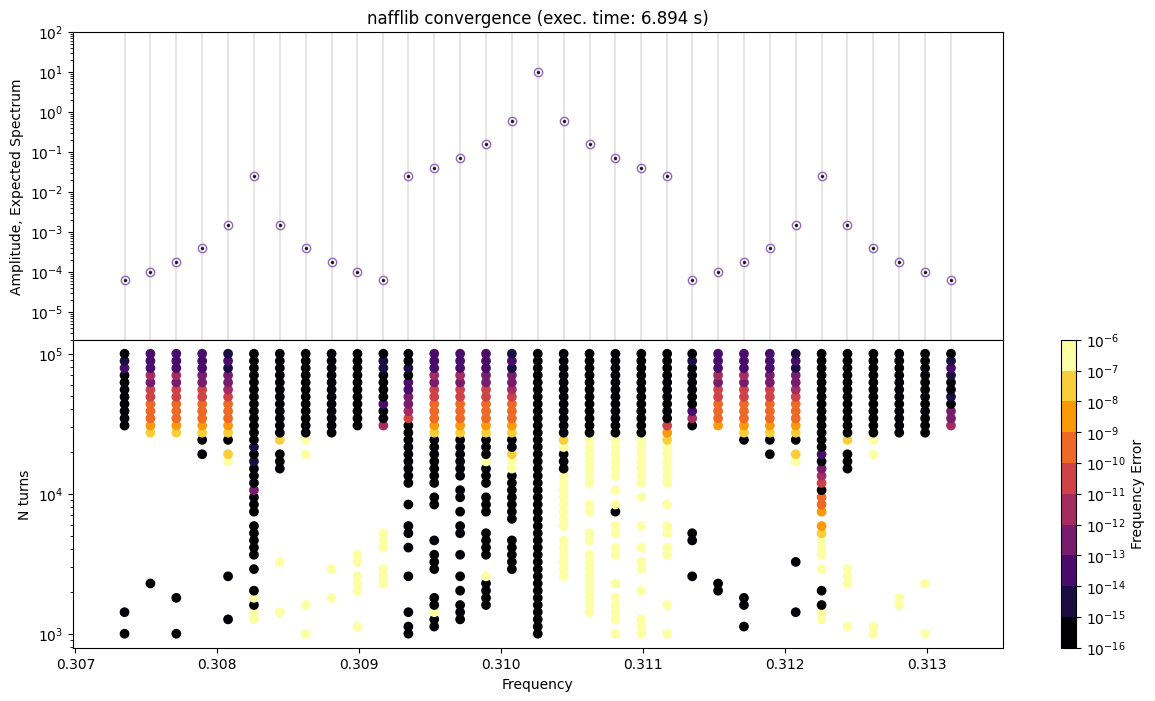

In [2]:


# Creating expected spectrum
#===========================
Q0    = 0.31025793875089835
param = 5*2*(np.pi/3)**2
A,Q,Q_vec,signal = dense_spectrum(Q0,param)
Qs = 0.002
dQ = Qs/param

cmap_name = 'inferno'
#===========================

# Looping for different number of turns
N_vec = np.logspace(3,5,40).astype(int)
N_list   = []
Q_list   = []
A_list   = []
errors_Q = []
errors_A = []
t1 = time.perf_counter()
for N in N_vec:

    # Extracting signal
    x,px = signal[0][:N],signal[1][:N]
    
    # nafflib
    A_found,Q_found = nafflib.harmonics(x,px,num_harmonics = len(Q),window_order = 4,window_type = 'hann')


    # Sorting lines and compiling errors
    #-----------------------------------
    r,_,_ = nafflib.find_linear_combinations(Q,fundamental_tunes= Q_vec)
    r_found,_,_ = nafflib.find_linear_combinations(Q_found,fundamental_tunes= Q_vec)

    for res,_A,_Q in zip(r,A,Q):
        if res in r_found:
            found_idx = r_found.index(res)
            errors_Q.append(Q_found[found_idx]-_Q)
            errors_A.append(np.abs(A_found[found_idx])-np.abs(_A))
        else:
            errors_Q.append(np.nan)
            errors_A.append(np.nan)
        Q_list.append(_Q)
        A_list.append(np.abs(_A))
        N_list.append(N)
    #-----------------------------------
t2 = time.perf_counter()

# PLOTTING
#=========================================
fig, axs = plt.subplots(2, 1,figsize=(15,8))
axs[0].set_title(f'nafflib convergence (exec. time: {t2-t1:.3f} s)')
plt.subplots_adjust(hspace=0)


# Bottom plot
#---------------
plt.sca(axs[1])
bounds = np.array([1e-16,1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

plt.scatter(Q_list,N_list,c=errors_Q,norm=norm,cmap=cmap_name)

cbar = plt.colorbar(label='Frequency Error',ticks=bounds)
cbar.ax.set_yticklabels([f'$10^{{{int(np.log10(b))}}}$' for b in bounds]) 


plt.yscale('log')
plt.xlim(np.min(Q)-2*dQ,np.max(Q)+2*dQ)
plt.xlabel('Frequency')
plt.ylabel('N turns')
#---------------


# Top plot
#---------------
plt.sca(axs[0])
plt.plot(Q,np.abs(A),'o',color='C4',alpha=1,mfc='none',label='EXPECTED')
plt.plot(Q_found,np.abs(A_found),'.',color='k',alpha=0.8,ms=3,label='nafflib')
plt.scatter(np.nan,np.nan)
cbar = plt.colorbar()
cbar.ax.set_visible(False)
plt.xticks([])

plt.yscale('log')
plt.xlim(Q0-10*Qs,Q0+10*Qs)
plt.ylabel('Amplitude, Expected Spectrum')
plt.xlim(np.min(Q)-2*dQ,np.max(Q)+2*dQ)
for line in Q:
    plt.axvline(line,color='k',alpha=0.1,zorder=-10)
plt.ylim(2e-6,1e2)
#---------------

---
# Position ONLY
---

(2e-06, 100.0)

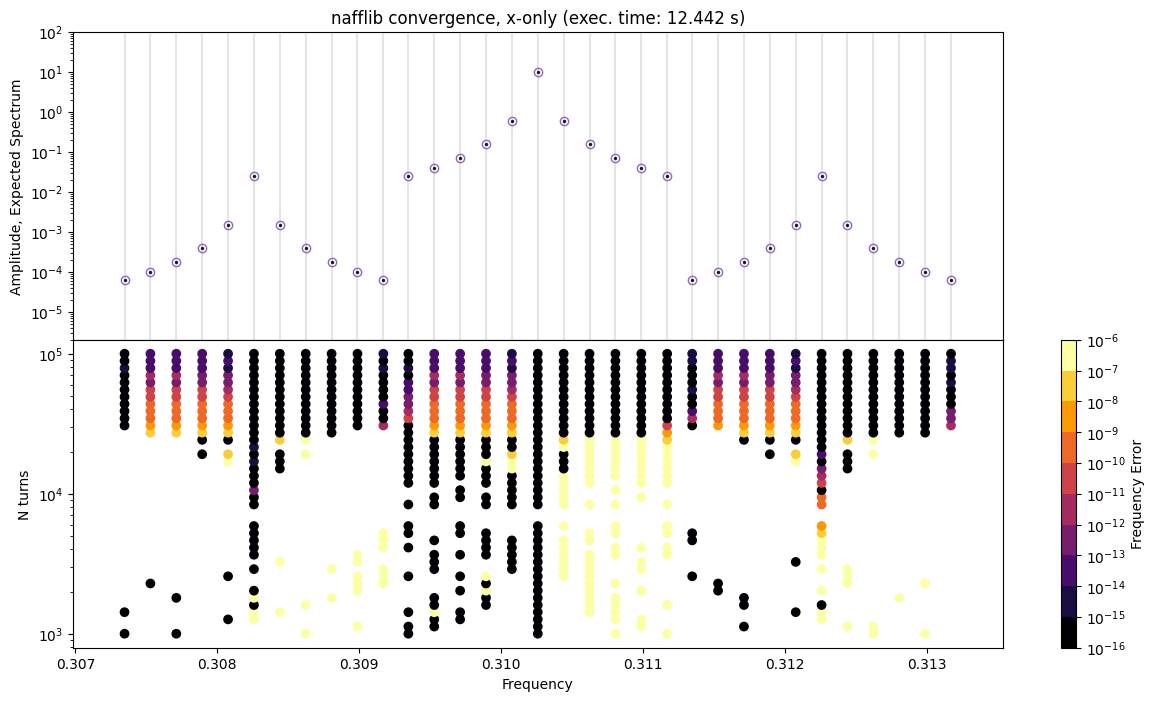

In [3]:


# Creating expected spectrum
#===========================
Q0    = 0.31025793875089835
param = 5*2*(np.pi/3)**2
A,Q,Q_vec,signal = dense_spectrum(Q0,param)
Qs = 0.002
dQ = Qs/param

cmap_name = 'inferno'
#===========================

# Looping for different number of turns
N_vec = np.logspace(3,5,40).astype(int)
N_list   = []
Q_list   = []
A_list   = []
errors_Q = []
errors_A = []
t1 = time.perf_counter()
for N in N_vec:

    # Extracting signal
    x,px = signal[0][:N],signal[1][:N]
    
    # nafflib
    A_found,Q_found = nafflib.harmonics(x,num_harmonics = len(Q),window_order = 4,window_type = 'hann')


    # Sorting lines and compiling errors
    #-----------------------------------
    r,_,_ = nafflib.find_linear_combinations(Q,fundamental_tunes= Q_vec)
    r_found,_,_ = nafflib.find_linear_combinations(Q_found,fundamental_tunes= Q_vec)

    for res,_A,_Q in zip(r,A,Q):
        if res in r_found:
            found_idx = r_found.index(res)
            errors_Q.append(Q_found[found_idx]-_Q)
            errors_A.append(np.abs(A_found[found_idx])-np.abs(_A))
        else:
            errors_Q.append(np.nan)
            errors_A.append(np.nan)
        Q_list.append(_Q)
        A_list.append(np.abs(_A))
        N_list.append(N)
    #-----------------------------------
t2 = time.perf_counter()

# PLOTTING
#=========================================
fig, axs = plt.subplots(2, 1,figsize=(15,8))
axs[0].set_title(f'nafflib convergence, x-only (exec. time: {t2-t1:.3f} s)')
plt.subplots_adjust(hspace=0)


# Bottom plot
#---------------
plt.sca(axs[1])
bounds = np.array([1e-16,1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

plt.scatter(Q_list,N_list,c=errors_Q,norm=norm,cmap=cmap_name)

cbar = plt.colorbar(label='Frequency Error',ticks=bounds)
cbar.ax.set_yticklabels([f'$10^{{{int(np.log10(b))}}}$' for b in bounds]) 


plt.yscale('log')
plt.xlim(np.min(Q)-2*dQ,np.max(Q)+2*dQ)
plt.xlabel('Frequency')
plt.ylabel('N turns')
#---------------


# Top plot
#---------------
plt.sca(axs[0])
plt.plot(Q,np.abs(A),'o',color='C4',alpha=1,mfc='none',label='EXPECTED')
plt.plot(Q_found,np.abs(A_found),'.',color='k',alpha=0.8,ms=3,label='nafflib')
plt.scatter(np.nan,np.nan)
cbar = plt.colorbar()
cbar.ax.set_visible(False)
plt.xticks([])

plt.yscale('log')
plt.xlim(Q0-10*Qs,Q0+10*Qs)
plt.ylabel('Amplitude, Expected Spectrum')
plt.xlim(np.min(Q)-2*dQ,np.max(Q)+2*dQ)
for line in Q:
    plt.axvline(line,color='k',alpha=0.1,zorder=-10)
plt.ylim(2e-6,1e2)
#---------------

---
# With a less dense spectrum, convergence is obviously better!
---

(2e-06, 100.0)

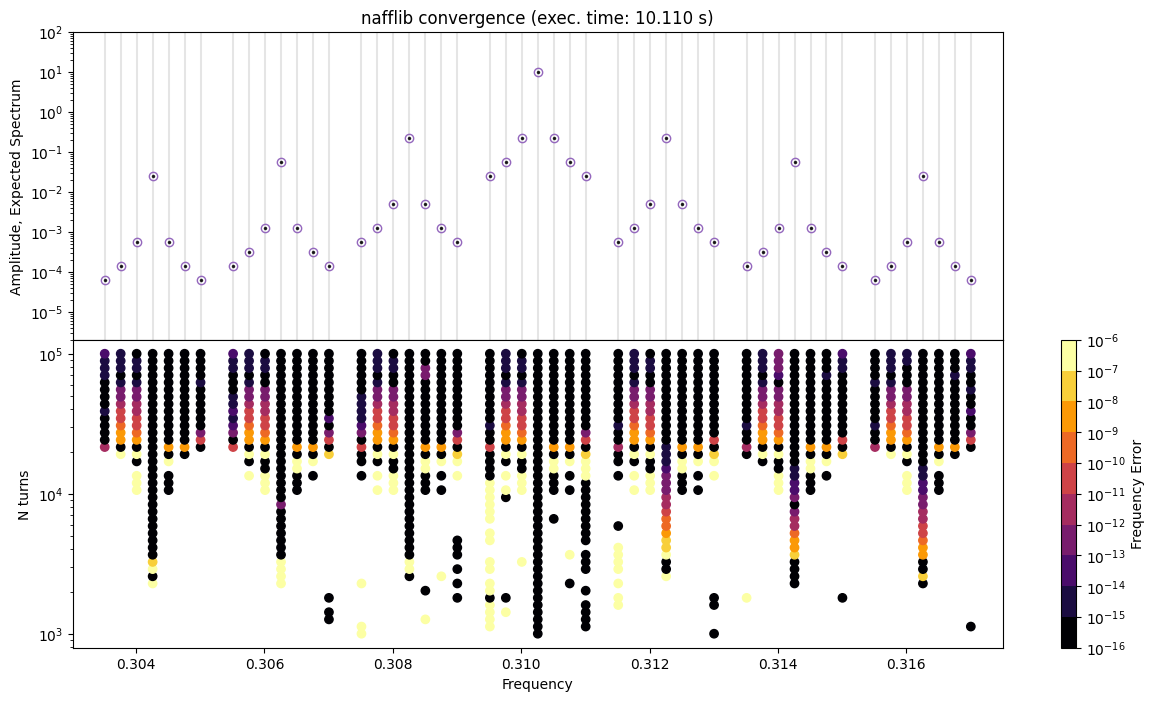

In [4]:


# Creating expected spectrum
#===========================
Q0    = 0.31025793875089835
param = 5*1.5*(np.pi/3)**1.5
A,Q,Q_vec,signal = dense_spectrum(Q0,param,n_bands_Qs=3,n_bands_dQ=3)
Qs = 0.002
dQ = Qs/param

cmap_name = 'inferno'
#===========================

# Looping for different number of turns
N_vec = np.logspace(3,5,40).astype(int)
N_list   = []
Q_list   = []
A_list   = []
errors_Q = []
errors_A = []
t1 = time.perf_counter()
for N in N_vec:

    # Extracting signal
    x,px = signal[0][:N],signal[1][:N]
    
    # nafflib
    A_found,Q_found = nafflib.harmonics(x,px,num_harmonics = len(Q),window_order = 4,window_type = 'hann')


    # Sorting lines and compiling errors
    #-----------------------------------
    r,_,_ = nafflib.find_linear_combinations(Q,fundamental_tunes= Q_vec)
    r_found,_,_ = nafflib.find_linear_combinations(Q_found,fundamental_tunes= Q_vec)

    for res,_A,_Q in zip(r,A,Q):
        if res in r_found:
            found_idx = r_found.index(res)
            errors_Q.append(Q_found[found_idx]-_Q)
            errors_A.append(np.abs(A_found[found_idx])-np.abs(_A))
        else:
            errors_Q.append(np.nan)
            errors_A.append(np.nan)
        Q_list.append(_Q)
        A_list.append(np.abs(_A))
        N_list.append(N)
    #-----------------------------------
t2 = time.perf_counter()

# PLOTTING
#=========================================
fig, axs = plt.subplots(2, 1,figsize=(15,8))
axs[0].set_title(f'nafflib convergence (exec. time: {t2-t1:.3f} s)')
plt.subplots_adjust(hspace=0)


# Bottom plot
#---------------
plt.sca(axs[1])
bounds = np.array([1e-16,1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

plt.scatter(Q_list,N_list,c=errors_Q,norm=norm,cmap=cmap_name)

cbar = plt.colorbar(label='Frequency Error',ticks=bounds)
cbar.ax.set_yticklabels([f'$10^{{{int(np.log10(b))}}}$' for b in bounds]) 


plt.yscale('log')
plt.xlim(np.min(Q)-2*dQ,np.max(Q)+2*dQ)
plt.xlabel('Frequency')
plt.ylabel('N turns')
#---------------


# Top plot
#---------------
plt.sca(axs[0])
plt.plot(Q,np.abs(A),'o',color='C4',alpha=1,mfc='none',label='EXPECTED')
plt.plot(Q_found,np.abs(A_found),'.',color='k',alpha=0.8,ms=3,label='nafflib')
plt.scatter(np.nan,np.nan)
cbar = plt.colorbar()
cbar.ax.set_visible(False)
plt.xticks([])

plt.yscale('log')
plt.xlim(Q0-10*Qs,Q0+10*Qs)
plt.ylabel('Amplitude, Expected Spectrum')
plt.xlim(np.min(Q)-2*dQ,np.max(Q)+2*dQ)
for line in Q:
    plt.axvline(line,color='k',alpha=0.1,zorder=-10)
plt.ylim(2e-6,1e2)
#---------------

(2e-06, 100.0)

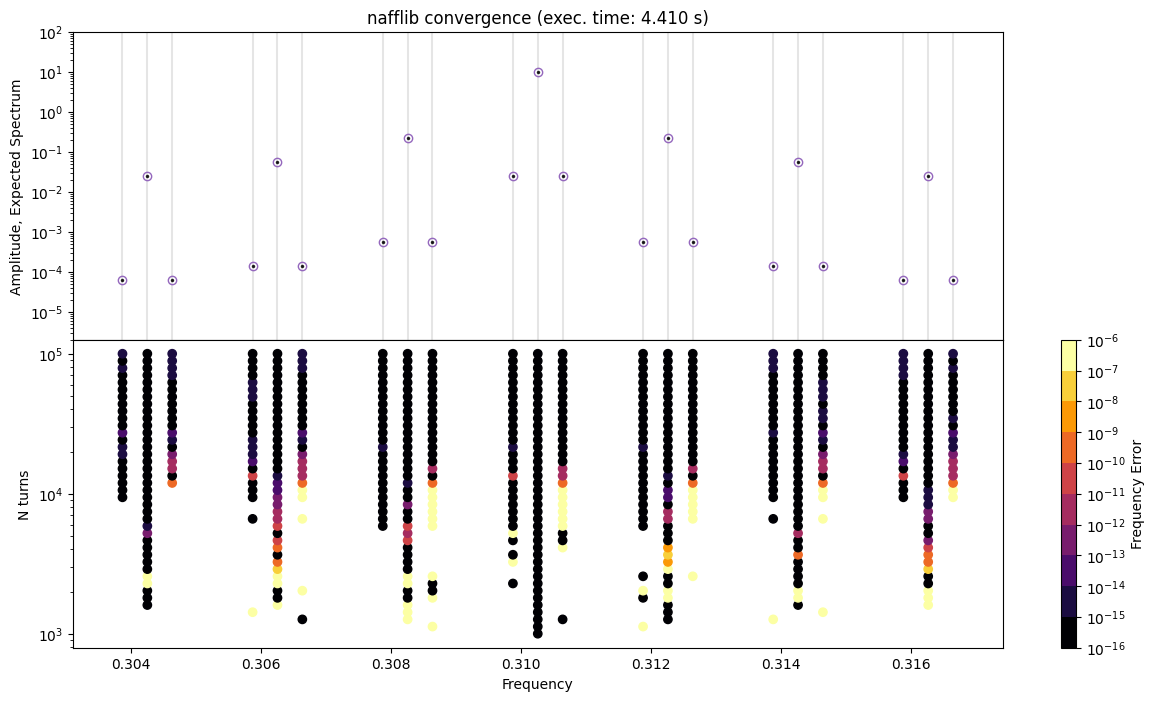

In [5]:


# Creating expected spectrum
#===========================
Q0    = 0.31025793875089835
param = 5*1*(np.pi/3)**1
A,Q,Q_vec,signal = dense_spectrum(Q0,param,n_bands_Qs=3,n_bands_dQ=1)
Qs = 0.002
dQ = Qs/param

cmap_name = 'inferno'
#===========================

# Looping for different number of turns
N_vec = np.logspace(3,5,40).astype(int)
N_list   = []
Q_list   = []
A_list   = []
errors_Q = []
errors_A = []
t1 = time.perf_counter()
for N in N_vec:

    # Extracting signal
    x,px = signal[0][:N],signal[1][:N]
    
    # nafflib
    A_found,Q_found = nafflib.harmonics(x,px,num_harmonics = len(Q),window_order = 4,window_type = 'hann')


    # Sorting lines and compiling errors
    #-----------------------------------
    r,_,_ = nafflib.find_linear_combinations(Q,fundamental_tunes= Q_vec)
    r_found,_,_ = nafflib.find_linear_combinations(Q_found,fundamental_tunes= Q_vec)

    for res,_A,_Q in zip(r,A,Q):
        if res in r_found:
            found_idx = r_found.index(res)
            errors_Q.append(Q_found[found_idx]-_Q)
            errors_A.append(np.abs(A_found[found_idx])-np.abs(_A))
        else:
            errors_Q.append(np.nan)
            errors_A.append(np.nan)
        Q_list.append(_Q)
        A_list.append(np.abs(_A))
        N_list.append(N)
    #-----------------------------------
t2 = time.perf_counter()

# PLOTTING
#=========================================
fig, axs = plt.subplots(2, 1,figsize=(15,8))
axs[0].set_title(f'nafflib convergence (exec. time: {t2-t1:.3f} s)')
plt.subplots_adjust(hspace=0)


# Bottom plot
#---------------
plt.sca(axs[1])
bounds = np.array([1e-16,1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

plt.scatter(Q_list,N_list,c=errors_Q,norm=norm,cmap=cmap_name)

cbar = plt.colorbar(label='Frequency Error',ticks=bounds)
cbar.ax.set_yticklabels([f'$10^{{{int(np.log10(b))}}}$' for b in bounds]) 


plt.yscale('log')
plt.xlim(np.min(Q)-2*dQ,np.max(Q)+2*dQ)
plt.xlabel('Frequency')
plt.ylabel('N turns')
#---------------


# Top plot
#---------------
plt.sca(axs[0])
plt.plot(Q,np.abs(A),'o',color='C4',alpha=1,mfc='none',label='EXPECTED')
plt.plot(Q_found,np.abs(A_found),'.',color='k',alpha=0.8,ms=3,label='nafflib')
plt.scatter(np.nan,np.nan)
cbar = plt.colorbar()
cbar.ax.set_visible(False)
plt.xticks([])

plt.yscale('log')
plt.xlim(Q0-10*Qs,Q0+10*Qs)
plt.ylabel('Amplitude, Expected Spectrum')
plt.xlim(np.min(Q)-2*dQ,np.max(Q)+2*dQ)
for line in Q:
    plt.axvline(line,color='k',alpha=0.1,zorder=-10)
plt.ylim(2e-6,1e2)
#---------------